In [1]:
import sys
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch

# Add project src and utils directories to path
sys.path.append(str((Path().resolve() / '../src').resolve()))
sys.path.append(str((Path().resolve() / '../utils').resolve()))

# Custom/project-specific imports
from config import BATCH_SIZE, RESULTS_DIR
from data_loader import load_images, resize_tensor_list
from augmentations import strong_augmentation, strong_aug_special_class
from losses import FocalLoss
from model import EfficientNetClassifier
from train_utils import evaluate_model, train_model
from utils import (
    encode_labels,
    plot_confusion_matrix,
    save_model,
    read_csv,
    show_sample_images,
)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
df_hierarchical = read_csv('../data/df_hierarchical.csv')

df_bags = df_hierarchical[df_hierarchical["group"] == "Bags"].copy()

df_bags_balanced = (
    df_bags
    .groupby("articleType")
    .apply(lambda x: x.sample(n=min(len(x), 1000), random_state=42))
    .reset_index(drop=True)
)

df_bags_balanced["articleType"].value_counts()

/var/folders/ry/xs98p9sd6y3_rkdt0nrtqsb00000gn/T/ipykernel_25982/576042209.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bags


articleType
Handbags    1000
Wallets      465
Clutches     290
Name: count, dtype: int64

In [4]:
df_bags_balanced, le_bags = encode_labels(df_bags_balanced, column='articleType', new_column='subcat_encoded', return_encoder=True)
print(list(le_bags.classes_))  # ['Clutches', 'Handbags', 'Wallets']

['Clutches', 'Handbags', 'Wallets']


In [5]:
AUGS = {
    "Clutches": strong_aug_special_class(),
    "Handbags": strong_augmentation(),
    "Wallets": strong_augmentation(),
}

X, y = load_images(df=df_bags_balanced, label_col='subcat_encoded', aug_map=AUGS)
X = resize_tensor_list(X)
y = torch.tensor(y, dtype=torch.long)

In [7]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [8]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([1404, 3, 224, 224])
X_val shape: torch.Size([175, 3, 224, 224])
X_test shape: torch.Size([176, 3, 224, 224])
y_train shape: torch.Size([1404])
y_val shape: torch.Size([175])
y_test shape: torch.Size([176])


In [9]:
print("Train class distribution:", np.unique(y_train, return_counts=True))
print("Validation class distribution:", np.unique(y_val, return_counts=True))
print("Test class distribution:", np.unique(y_test, return_counts=True))

Train class distribution: (array([0, 1, 2]), array([232, 800, 372]))
Validation class distribution: (array([0, 1, 2]), array([ 29, 100,  46]))
Test class distribution: (array([0, 1, 2]), array([ 29, 100,  47]))


In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

/var/folders/ry/xs98p9sd6y3_rkdt0nrtqsb00000gn/T/ipykernel_25982/1938720079.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/var/folders/ry/xs98p9sd6y3_rkdt0nrtqsb00000gn/T/ipykernel_25982/1938720079.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/var/folders/ry/xs98p9sd6y3_rkdt0nrtqsb00000gn/T/ipykernel_25982/1938720079.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=to

In [11]:
# Calculate class-balanced alpha weights for bags
label_counts = df_bags_balanced['subcat_encoded'].value_counts().sort_index().to_numpy()
max_count = label_counts.max()

# NumPy-based, always float, auto-round to 2 decimals
alpha_weights = np.round(max_count / label_counts, 2).astype(float)
alpha_tensor = torch.tensor(alpha_weights, dtype=torch.float32, device=device)

print("Alpha weights:", alpha_weights.tolist())

Alpha weights: [3.45, 1.0, 2.15]


In [12]:
model = EfficientNetClassifier(num_classes=len(list(le_bags.classes_))).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = FocalLoss(gamma=2.0, alpha=alpha_tensor)

/Users/hossein/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hossein/.pyenv/versions/3.9.18/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/hossein/Desktop/School/deep_learning_TDIS22/hierarchical-image-classification/src/losses.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha

In [13]:
EPOCHS = 15
history = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    device=device,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    print_every=1
)

Epoch 1/15 | Loss: 25.563 | Acc: 65.17% | Val Loss: 1.999 | Val Acc: 83.43%
Epoch 2/15 | Loss: 10.886 | Acc: 88.46% | Val Loss: 1.134 | Val Acc: 86.29%
Epoch 3/15 | Loss: 6.296 | Acc: 92.45% | Val Loss: 0.895 | Val Acc: 89.14%
Epoch 4/15 | Loss: 4.134 | Acc: 95.01% | Val Loss: 0.773 | Val Acc: 89.14%
Epoch 5/15 | Loss: 2.998 | Acc: 96.08% | Val Loss: 0.739 | Val Acc: 90.29%
Epoch 6/15 | Loss: 2.175 | Acc: 97.93% | Val Loss: 0.741 | Val Acc: 90.29%
Epoch 7/15 | Loss: 1.478 | Acc: 98.36% | Val Loss: 0.718 | Val Acc: 89.71%
Epoch 8/15 | Loss: 1.343 | Acc: 98.65% | Val Loss: 0.709 | Val Acc: 91.43%
Epoch 9/15 | Loss: 0.830 | Acc: 99.36% | Val Loss: 0.710 | Val Acc: 90.86%
Epoch 10/15 | Loss: 0.676 | Acc: 99.29% | Val Loss: 0.697 | Val Acc: 90.86%
Epoch 11/15 | Loss: 0.508 | Acc: 99.50% | Val Loss: 0.729 | Val Acc: 90.86%
Epoch 12/15 | Loss: 0.441 | Acc: 99.50% | Val Loss: 0.736 | Val Acc: 91.43%
Epoch 13/15 | Loss: 0.392 | Acc: 99.64% | Val Loss: 0.746 | Val Acc: 90.86%
Epoch 14/15 | Loss:

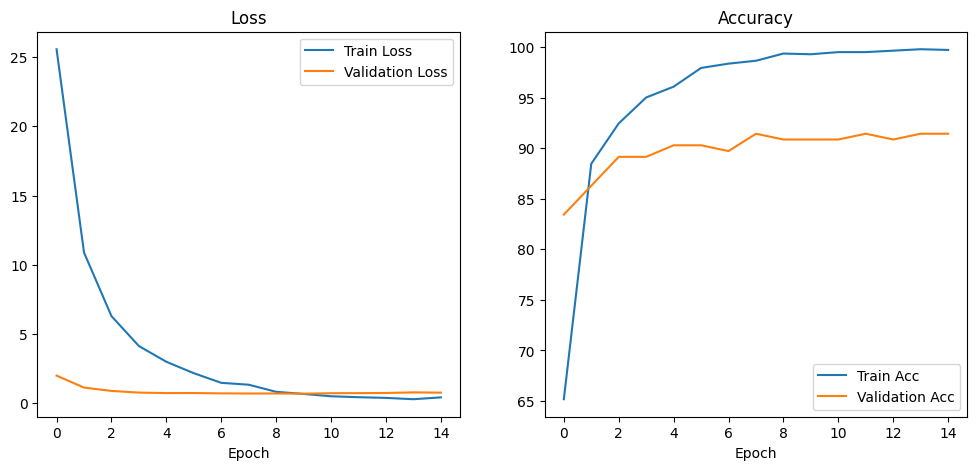

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Validation Acc')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epoch')

plt.show()

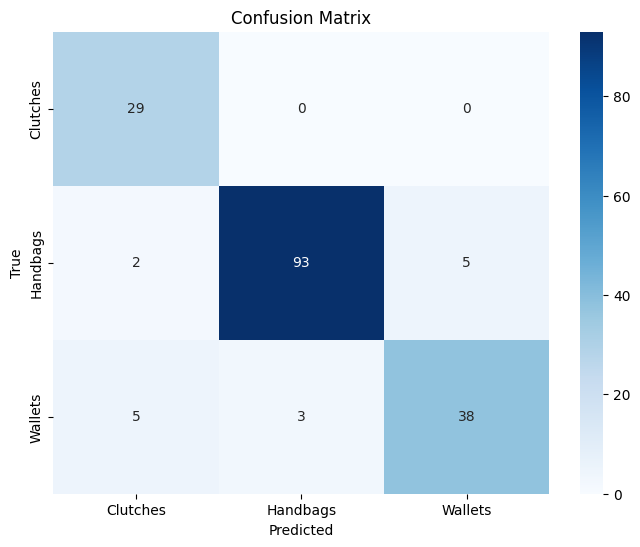

              precision    recall  f1-score   support

    Clutches       0.81      1.00      0.89        29
    Handbags       0.97      0.93      0.95       100
     Wallets       0.88      0.83      0.85        46

    accuracy                           0.91       175
   macro avg       0.89      0.92      0.90       175
weighted avg       0.92      0.91      0.91       175



In [15]:
true_labels, pred_labels = evaluate_model(model, X_val_tensor, y_val_tensor, device, batch_size=BATCH_SIZE)

# confusion matrix
plot_confusion_matrix(true_labels, pred_labels, classes=list(le_bags.classes_), title='Confusion Matrix')

# classification report
print(classification_report(true_labels, pred_labels, target_names=list(le_bags.classes_)))

In [16]:
# Save the model
save_model(model, RESULTS_DIR / 'model_bags_classifier.pth')

In [17]:
# Save training history
with open(RESULTS_DIR / 'history_bags_classifier.json', "w") as f:
    json.dump(history, f)

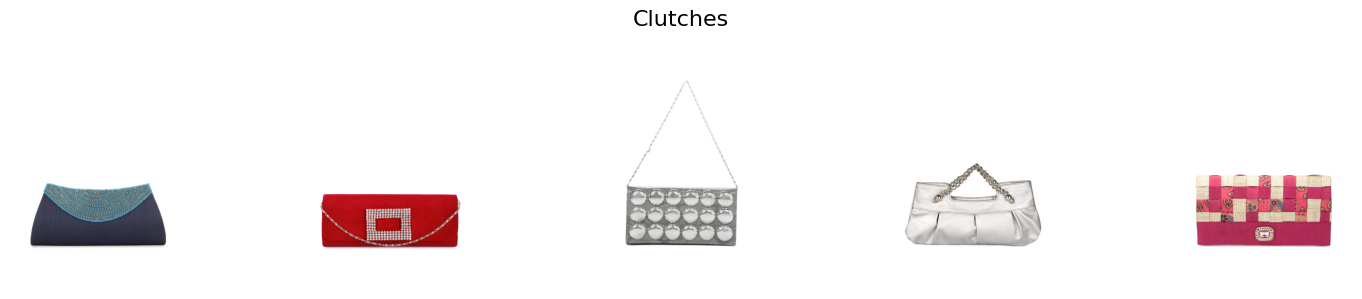

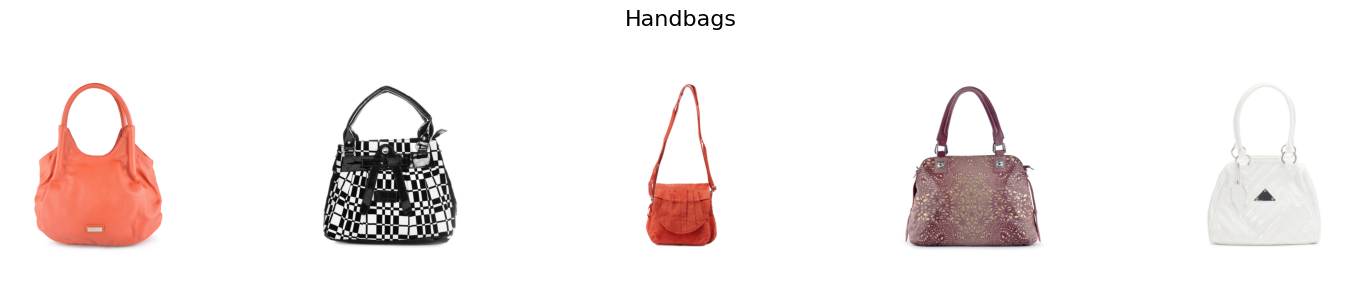

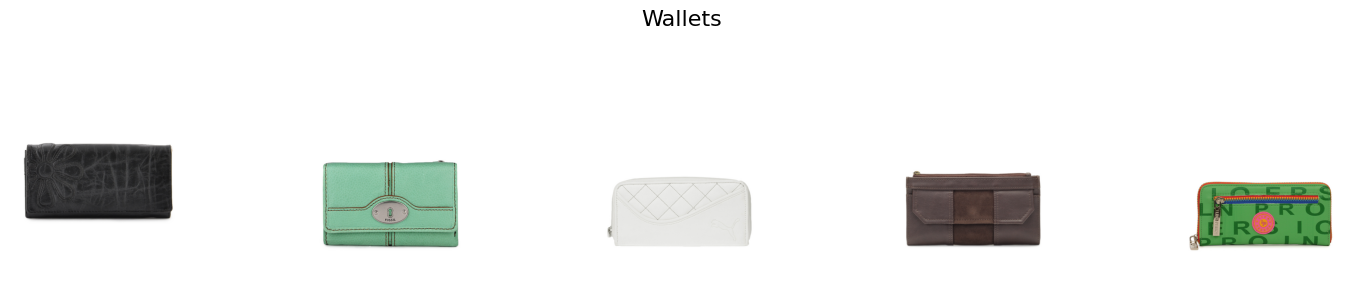

In [18]:
show_sample_images(df_bags_balanced)